In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
        print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
        print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
Last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

Last_data_point

('2017-08-23')

In [13]:
# Perform a query to retrieve the date and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').all()

prcp_all_df = pd.DataFrame(results)
prcp_all_df.set_index('date', inplace=True, )

In [14]:
# Sort the dataframe by date
prcp_all_df.sort_values(by=['date'], inplace=True)

#Remove NaN
prcp_df = prcp_all_df.dropna(how='any')

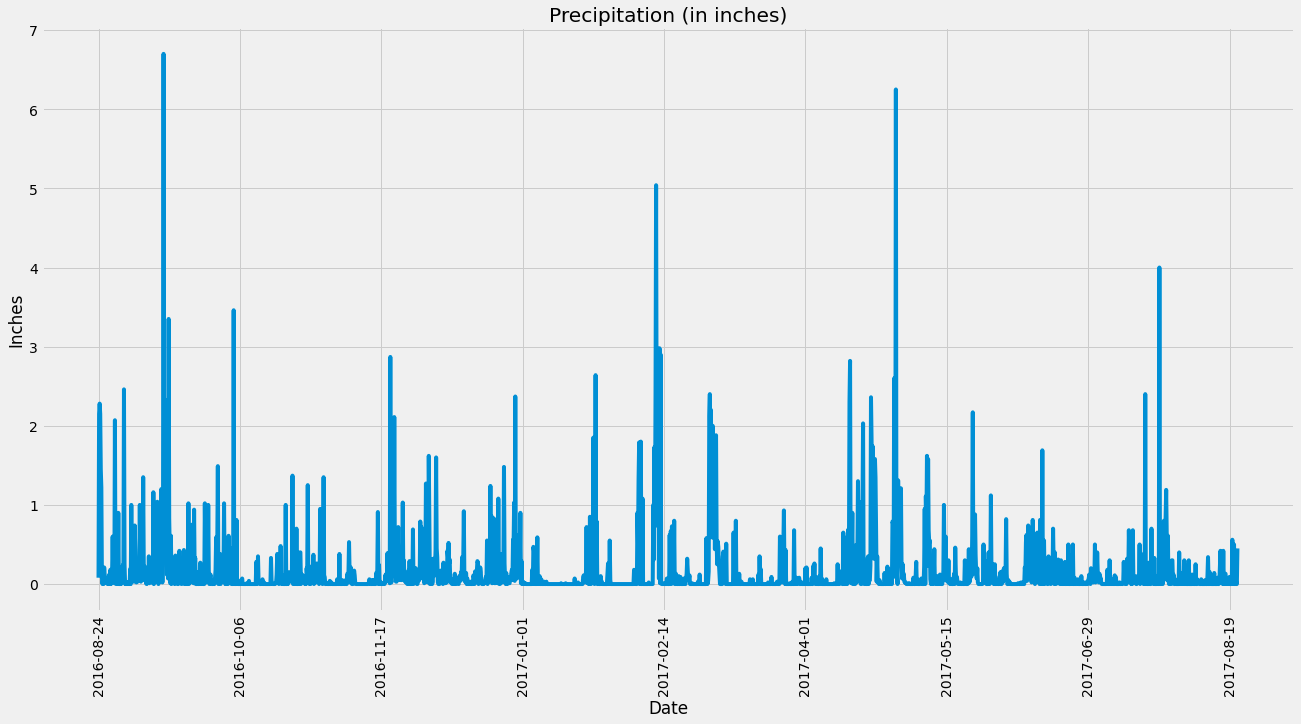

In [15]:
prcp_df.plot(rot = 90, legend = False, figsize=(20,10))
plt.title("Precipitation (in inches)")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
Summary_df = prcp_df.agg(
    {    "prcp": ["mean", "median", "var", "std", "sem"] })

Summary_df

,prcp
mean,0.176462
median,0.020000
var,0.211865
std,0.460288
sem,0.010254


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).group_by(Station.station).count()


9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded at the most active station. 
most_active = 'USC00519281'

Lowest_temp = session.query(func.min(Measurement.tobs).filter(Measurement.station == most_active)).all()

Lowest_temp

[(54.0)]

In [20]:
# Highest temperature recorded at the most active station
Highest_temp = session.query(func.max(Measurement.tobs).filter(Measurement.station == most_active)).all()

Highest_temp

[(85.0)]

In [21]:
# Average temperature of the most active station
Average_temp = session.query(func.avg(Measurement.tobs).filter(Measurement.station == most_active)).all()

Average_temp

[(71.66378066378067)]

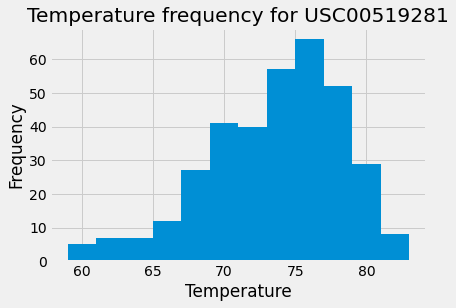

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.date > '2016-08-23').\
filter(Measurement.station == most_active).all()

station_temps_df = pd.DataFrame(results)

station_temps_df.plot.hist(bins=12, legend=False)
plt.title("Temperature frequency for USC00519281")
plt.xlabel("Temperature")
plt.show()




## Bonus Challenge Assignment

### Temperature Analysis 1

Average June Temp

In [23]:
results = session.query(Measurement.date, Measurement.tobs).all()

#Put query results in dataframe
total_prcp_df = pd.DataFrame(results)

#Convert date column from string to datetime
total_prcp_df['date'] = pd.to_datetime(total_prcp_df['date'])

#Create dataframe with just June data
June_prcp_df = total_prcp_df[total_prcp_df['date'].dt.month == 6]

Avg_June = June_prcp_df['tobs'].mean()

Avg_June

74.94411764705882

Average December Temp

In [24]:
#Create dataframe with just June data
Dec_prcp_df = total_prcp_df[total_prcp_df['date'].dt.month == 12]

Avg_Dec = Dec_prcp_df['tobs'].mean()

Avg_Dec

71.04152933421226

T-Test

In [25]:
#Use a paired t-test to compare the mean of one population to another

stats.ttest_ind(June_prcp_df['tobs'], Dec_prcp_df['tobs'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

Null hypothesis - There is no statistical difference between the two months

P-value is less than 0.05, so we reject the null hypothesis.

### Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


Dates of Trip - 2/10 - 2/17

In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_result = (calc_temps('2017-02-10','2017-02-17'))

trip_result

[(62.0, 71.75, 80.0)]

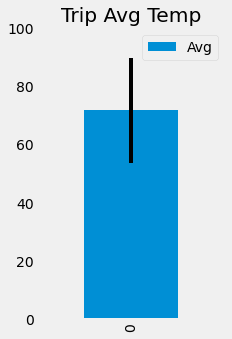

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Trip_avg = trip_result[0][1]
Trip_max = trip_result[0][2]
Trip_min = trip_result[0][0]

plot_dict = [{"Avg":Trip_avg}]
plot_df = pd.DataFrame(plot_dict)

plot_df.plot(kind = "bar", title = "Trip Avg Temp", grid=False, figsize=(3,5), yerr = (Trip_max - Trip_min))
plt.ylim(0,100)
plt.show()




In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Total_prcp = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-02-10').filter(Measurement.date <= '2017-02-17').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

Total_prcp

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  5.84),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  5.7700000000000005),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  5.589999999999999),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  4.9799999999999995),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 3.01),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.7699999999999996),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
# Set the start and end date of the trip
start_date = "02-10-2018"
end_date= "02-17-2018"

# Use the start and end date to create a range of dates
dates = pd.date_range((pd.to_datetime(start_date)),pd.to_datetime(end_date)-dt.timedelta(days=0),freq='d')

without_years = []
for date in dates:
    x = date.strftime("%m-%d")
    without_years.append(x)


In [51]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

for date in without_years:
    normal = daily_normals(date)
    normals.append(normal[0])

normals

[(56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0),
 (59.0, 70.48214285714286, 76.0),
 (62.0, 70.47272727272727, 77.0)]

In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, columns = ['tmin', 'tavg','tmax'])
normal_df['date'] = dates
normal_df = normal_df.set_index("date")

normal_df

,tmin,tavg,tmax
date,,,
2018-02-10,56.0,68.416667,76.0
2018-02-11,61.0,69.250000,79.0
2018-02-12,60.0,69.157895,78.0
2018-02-13,58.0,70.362069,80.0
2018-02-14,62.0,70.894737,79.0
2018-02-15,56.0,70.288136,79.0
2018-02-16,59.0,70.482143,76.0
2018-02-17,62.0,70.472727,77.0


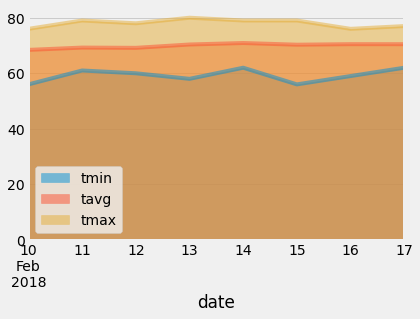

In [67]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False)
plt.show()